### fMRI Dimensionality Reduction

### Notebook setup

In [20]:
# NiLearn
from nilearn.datasets import fetch_development_fmri
import nilearn.plotting as plotting
from nilearn import image

# Nibabel to access file formats
import nibabel as nib

# Numpy to deal with arrays
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("RdBu")

# Built in python libraries
import random

# Set random seed for reproducibility
SEED = 11
random.seed(11)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Load the data

The `data` variable is a `Bunch` (dict. like object) with the following attributes:

- `func (list of str)`: Paths to downsampled functional MRI data (4D) for each subject.

- `confounds (list of str)`: Paths to confounds related to each subject. (tsv files)

- `phenotypic (numpy.ndarray)`: Contains each subject age, age group, child or adult, gender, handedness.

In [21]:
# Load the data using the nilearn's fetcher
global N_SUBJECTS 
N_SUBJECTS = 25

data = fetch_development_fmri(n_subjects=N_SUBJECTS, data_dir='./data', resume=True, verbose=1)

# Check the path to the data
print(f"First subject functional nifti images (4D) are at: {data.func[0]}")

First subject functional nifti images (4D) are at: ./data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [22]:
# Initialize features from dataset's description
global IPS
IPS = 168 
global N_SLICES
N_SLICES = 50 
global X_DIM
X_DIM = 50
global Y_DIM 
Y_DIM = 59

### Check the phenotypic data

Let's load the phenotypic data into a pandas dataframe to check the data.

In [23]:
# Convert the phenotypic data into a pandas dataframe ensuring the correct data types
data_types = {
    'participant_id': str,
    'Age': int,
    'AgeGroup': str,
    'Child_Adult': str,
    'Gender': str,
    'Handedness': str,
}
phenotypic = pd.DataFrame(data.phenotypic, columns=data_types.keys()).astype(data_types)

# Check the phenotypic data
phenotypic.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27,Adult,adult,F,R
1,sub-pixar124,33,Adult,adult,M,R
2,sub-pixar125,31,Adult,adult,M,R
3,sub-pixar126,19,Adult,adult,F,R
4,sub-pixar127,23,Adult,adult,F,R


Let's plot the distributions of the individual variables.

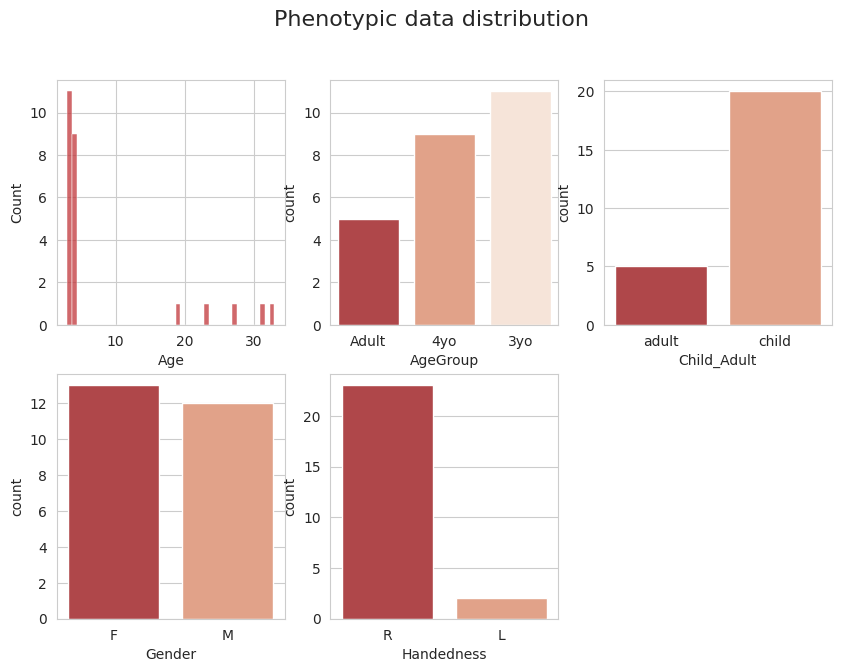

In [24]:
# The figure will have 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(10, 7))

# Plot the distribution of the age
sns.histplot(data=phenotypic, x="Age", ax=axs[0, 0], kde=False);

# Plot the categorical vars
sns.countplot(data=phenotypic, x='AgeGroup', ax=axs[0, 1])
sns.countplot(data=phenotypic, x='Child_Adult', ax=axs[0, 2])
sns.countplot(data=phenotypic, x='Gender', ax=axs[1, 0])
sns.countplot(data=phenotypic, x='Handedness', ax=axs[1, 1])

# Turn of the last axis
axs[1, 2].axis('off');

# Set the title
fig.suptitle("Phenotypic data distribution", fontsize=16);

# Save the figure
fig.savefig('figures/phenotypic_data_distribution.png', dpi=300)

### Visualize the subject

Let's dive into visualization of random subject.

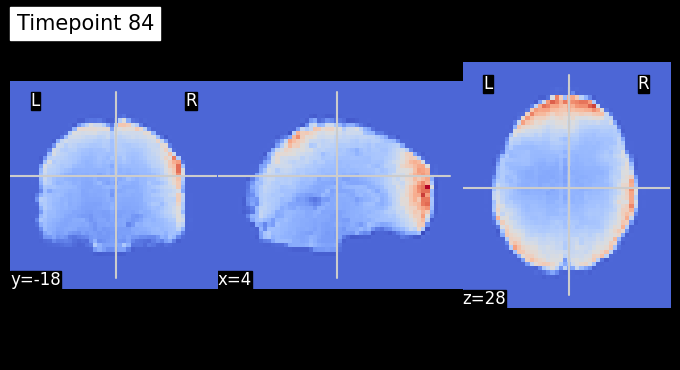

In [25]:
# Select a random subject 
subj_i = np.random.randint(0, N_SUBJECTS-1)

# Plot fMRI 3D volume (we choose the timepoint in the middle of the acquisition)
subj_vol = nib.load(data.func[subj_i])
TR_i = round(IPS/2) 
plotting.plot_epi(image.index_img(subj_vol, TR_i),  cmap = 'coolwarm', title=f"Timepoint {TR_i}")
plt.show()


### Initialize matrices and add noise

We now load the NIFTI images as numpy matrices, and store them in a x_dim x y_dim x n_subj matrix.
To do so, we must select a TR and slice. We choose the middle TR for effect compensation and middle slice since z coordinate in the middle allows for better visualization.

In [66]:
# Now we choose a TR
TR = round(IPS/2)

# and a slice 
sel_slice = round(N_SLICES/2)

# Now we import each NIFTI image as numpy matrix, then select desired TR+slice
matrices_4D = []
matrices_2D = []
for i in range(N_SUBJECTS):
    img_i = nib.load(data.func[i])
    mat_i = img_i.get_fdata()
    #print(f"Upload of subject {i} completed...")
    matrices_4D.append(mat_i)
    matrices_2D.append(mat_i[:,:,sel_slice, TR])
print("Matrices loaded.")

Matrices loaded.


In [88]:
# Add salt (white) noise by randomly setting some pixels of the matrix to 255
salt_int = 4000  # Max pixel value
salt_p = 0.01  # Probability of adding the noise

# Iterate over pixels and matrices 
noisy_mats = []
for k in range(N_SUBJECTS):
    noisy_mat = np.copy(matrices_2D[k])
    for i in range(noisy_mat.shape[0]):
        for j in range(noisy_mat.shape[1]):
            if random.random() < salt_p:
                noisy_mat[i,j] = salt_int
    noisy_mats.append(noisy_mat)

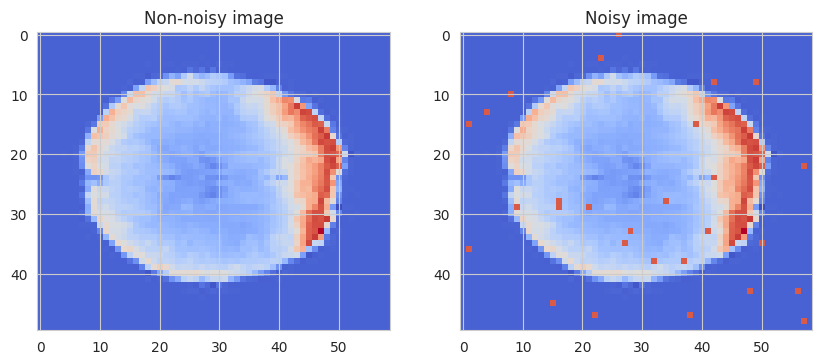

In [89]:
# Evaluate the result on a random subject
subj_i = np.random.randint(0, N_SUBJECTS-1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the non-noisy image
ax1.imshow(matrices_2D[subj_i], cmap = 'coolwarm')
ax1.set_title('Non-noisy image')

# Plot the noisy image
ax2.imshow(noisy_mats[subj_i], cmap = 'coolwarm')
ax2.set_title('Noisy image')

# Adjust layout and show plots
plt.show()

### Denoising with SVD

We generate the covariance matrix across subjects, then apply SVD to it and plot the computed values for every subject. We then project each individual matrix onto its 2 principal components. Denoised matrix is then restored and compared with the original denoised matrix.

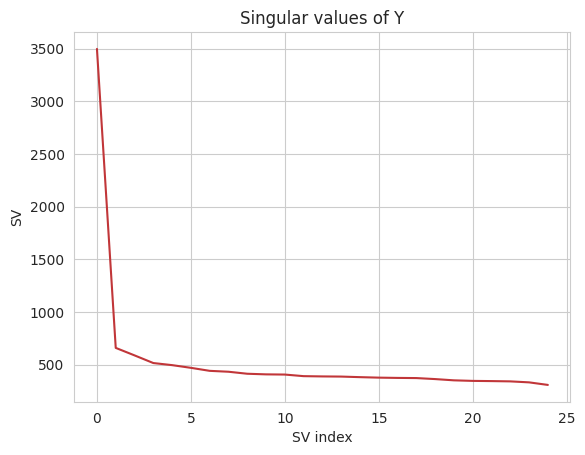

In [90]:
# Generate covariance matrix
noisy_arrays = np.zeros([X_DIM*Y_DIM, N_SUBJECTS])
for k in range(N_SUBJECTS):
    noisy_arrays[:,k] = noisy_mats[k].flatten()
cov_mat = np.cov(noisy_arrays.T)

# Perform SVD
U, S_2, Vt = np.linalg.svd(cov_mat, full_matrices = False)

# Plot singular values of Y
S = np.sqrt(S_2)
plt.plot(S)
plt.xlabel('SV index')
plt.ylabel('SV')
plt.title('Singular values of Y')
plt.grid(True)
plt.show()


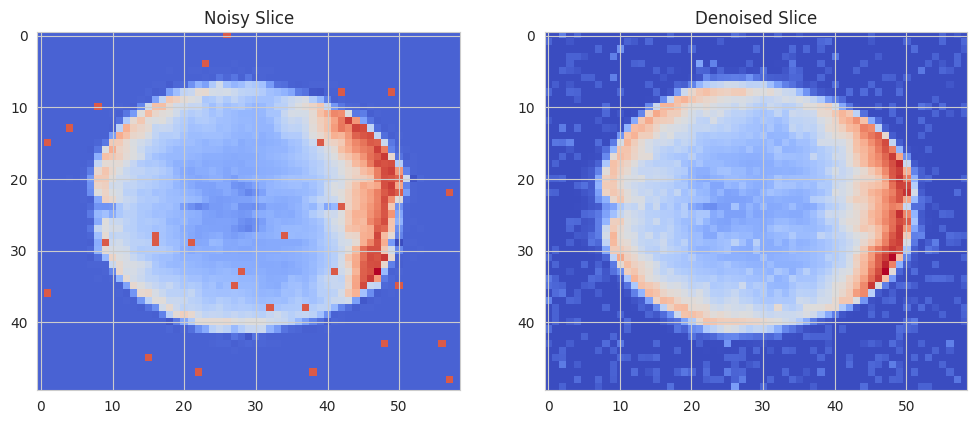

In [91]:
# Pick the 2 principal components from SVD
n_components = 1
princ_comp = U[:,:n_components]

# Project the matrix onto them
space_vectors = np.dot(princ_comp.T, noisy_arrays.T)
denoised_arrays = np.dot(princ_comp, space_vectors)
denoised_matrix = np.reshape(denoised_arrays[subj_i, :], [50,59])

# Visualize it
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(noisy_mats[subj_i], cmap='coolwarm')
plt.title('Noisy Slice')

plt.subplot(1, 2, 2)
plt.imshow(denoised_matrix, cmap='coolwarm')
plt.title('Denoised Slice')

plt.show()

### Behaviour Analysis with PLSC
Use PLSC to maximize cross-covariance between behavioural and fMRI datasets

In [12]:
# Extract the "Child_Adult" column (3rd column)
child_adult_labels = phenotypic.iloc[:, 3]
print(child_adult_labels)
# Now, you have the fMRI data in the 'data' variable
# and the "Child_Adult" labels in the 'child_adult_labels' variable.

0     adult
1     adult
2     adult
3     adult
4     adult
5     child
6     child
7     child
8     child
9     child
10    child
11    child
12    child
13    child
14    child
15    child
16    child
17    child
18    child
19    child
20    child
21    child
22    child
23    child
24    child
Name: Child_Adult, dtype: object


In [13]:
# Create a boolean Series `adult_obj` by checking if each element
# in the 'child_adult_labels' column is equal to 'adult'
adult_obj = (child_adult_labels == 'adult')

# Create another boolean Series `child_obj` by negating the values of `adult_obj`
child_obj =  ~adult_obj

column_adult = np.where(adult_obj, 1, 0)     #It sets the value to 1 where `adult_obj` is `True`, and 0 where it's `False`
column_child = np.where(child_obj, 1, 0)     #It sets the value to 1 where `child_obj` is `True` (i.e., 'child' labels) and 0 where it's `False`

child_adult_final = np.array([column_adult, column_child]).T
adult_child_df = pd.DataFrame(child_adult_final)

new_headers = [ 'Adults', 'Child']
adult_child_df.columns = new_headers
print(adult_child_df)

    Adults  Child
0        1      0
1        1      0
2        1      0
3        1      0
4        1      0
5        0      1
6        0      1
7        0      1
8        0      1
9        0      1
10       0      1
11       0      1
12       0      1
13       0      1
14       0      1
15       0      1
16       0      1
17       0      1
18       0      1
19       0      1
20       0      1
21       0      1
22       0      1
23       0      1
24       0      1


In [14]:
# Load your visual mask from a .nii file
mask_path = './data/mask'
mask_name = 'vis_mask.nii'
visual_mask = nib.load("/".join([mask_path,mask_name]))
visual_mask_mat = visual_mask.get_fdata()

# On every subject: perform temporal averaging 
# apply mask 
# save in arrays 
matrices_3D = []
masked_matrices = []
masked_arrays = np.zeros([X_DIM*Y_DIM*N_SLICES,N_SUBJECTS])
for k in range(N_SUBJECTS):
    mat = matrices_4D[k]
    print(f"subj {k+1}")
    matrices_3D.append(np.mean(mat, axis=3))
    masked_matrices.append(matrices_3D[k] * visual_mask_mat)
    masked_arrays[:,k] = masked_matrices[k].flatten()
print("Cell execution completed")

subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
Cell execution completed


In [15]:
# Compute behavior-spatial covariance matrix
Z = child_adult_final.T
R = np.dot(Z, masked_arrays.T)

# Perform Singular Value Decomposition
U, D_2, V = np.linalg.svd(R, full_matrices=False)
D = np.sqrt(D_2)

# Get latent variables 
Ly = np.dot(V, masked_arrays)
Lz = np.dot(U, Z)

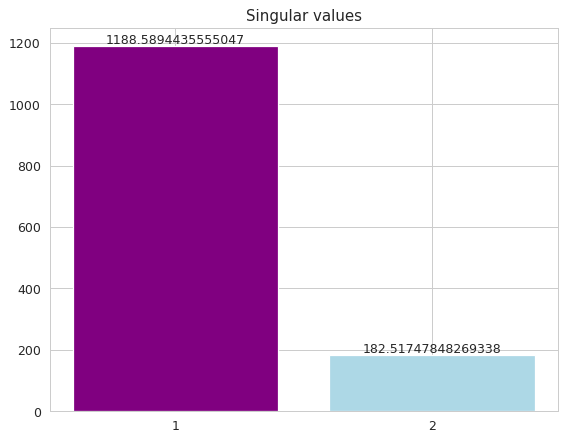

In [16]:
# Visualization
# Plot singular values explaining the covariance between brain contrast maps and behavioral measures
plt.figure(dpi=90)
bar1 = plt.bar(1, D[0] ,color='purple')
bar2 = plt.bar(2, D[1] ,color='lightblue')
for i, rect in enumerate(bar1 + bar2):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{D[i]}', ha='center', va='bottom')
plt.xticks([1,2]) 
plt.tight_layout()
plt.title("Singular values")
plt.show()

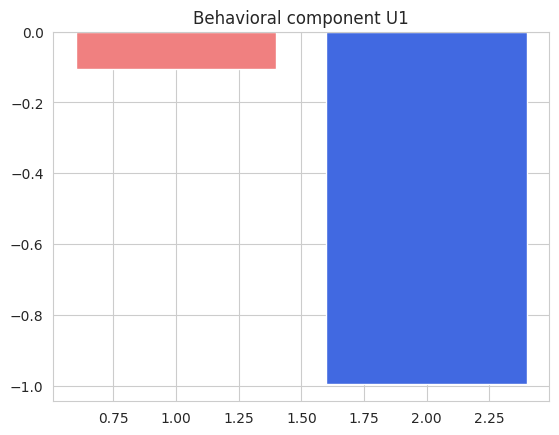

In [17]:
# Plot the behavioral components (matrix U)
# Plot Behavioral Component U1
plt.bar([1,2], U[0,:], color=['lightcoral','royalblue'])
plt.title("Behavioral component U1")
plt.show()

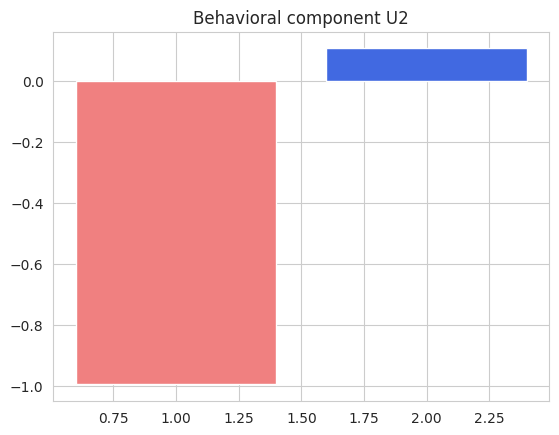

In [18]:
# Plot the behavioral components (matrix U)
# Plot Behavioral Component U2
plt.bar([1,2], U[1,:], color=['lightcoral','royalblue'])
plt.title("Behavioral component U2")
plt.show()

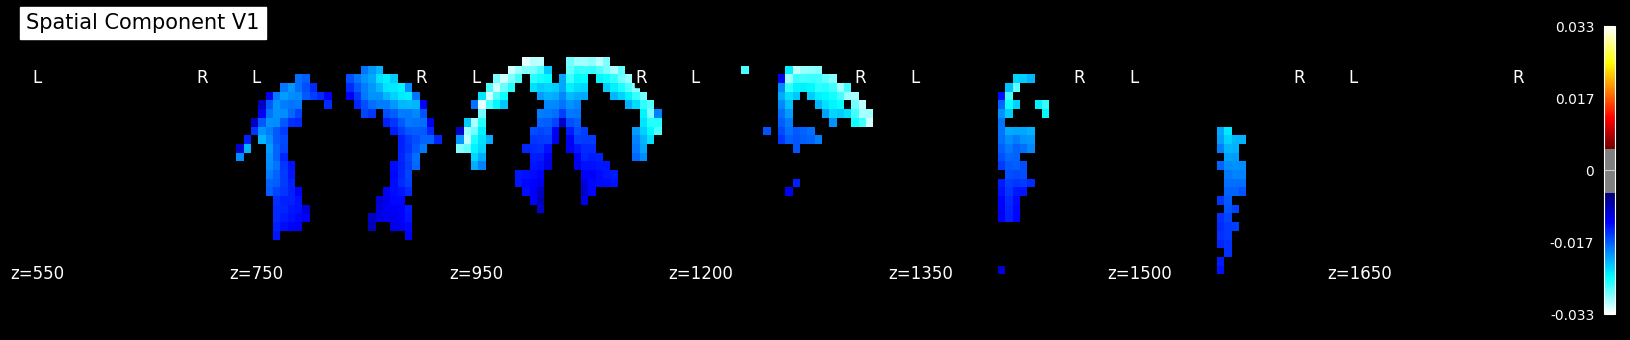

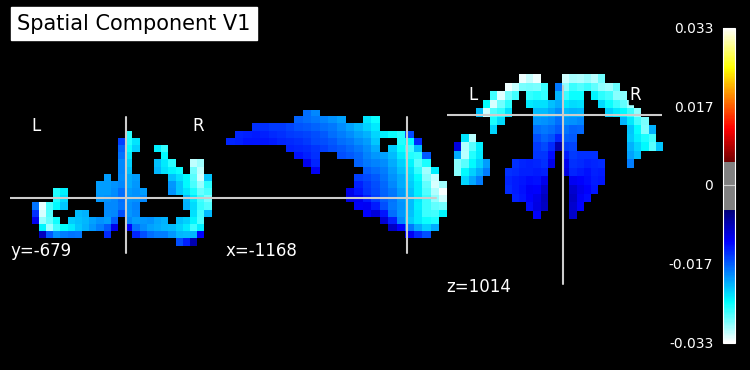

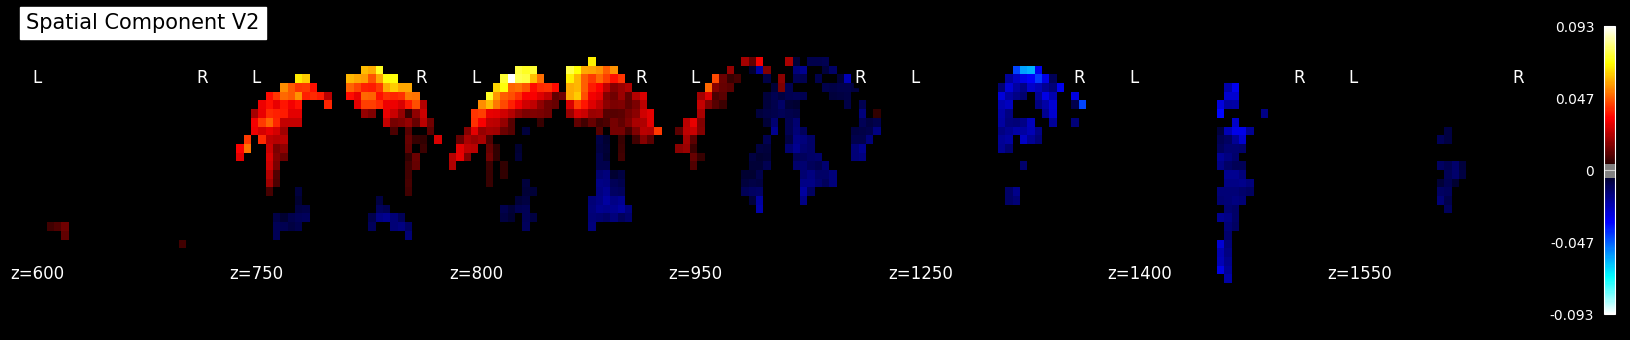

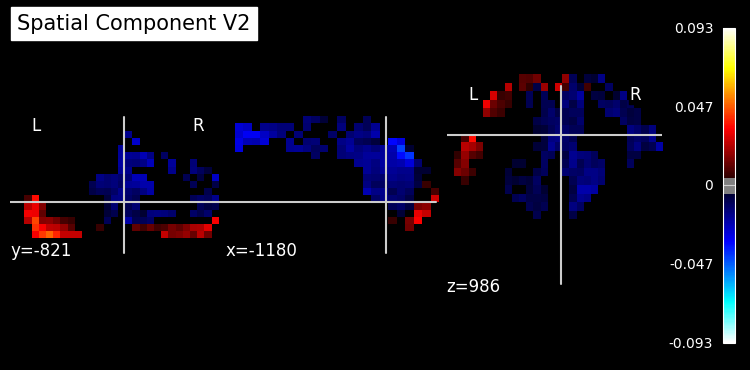

In [92]:
# Plot the spatial components (matrix V)
affine = np.array([
    [-X_DIM, 0, 0, 0],
    [0, -Y_DIM, 0, 0],
    [0, 0, N_SLICES, 0],
    [0, 0, 0, 1]
])
# ^^This will later be substituted

#Component V1
V1_img = nib.Nifti1Image(np.reshape(V[0,:],(X_DIM, Y_DIM, N_SLICES)), affine)

# Plot different views
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plotting.plot_stat_map(V1_img, display_mode=view_, title='Spatial Component V1',
                    colorbar=True, black_bg=True,  threshold=2*np.std(V[0,:]),)
                    #output_file=save_results + "pls_spatial_V1_{}.png".format(view_)) # uncomment to save plot

#Component V2
V2_img = nib.Nifti1Image(np.reshape(V[1,:],(X_DIM, Y_DIM, N_SLICES)), affine)

# Plot 
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plotting.plot_stat_map(V2_img, display_mode=view_, title='Spatial Component V2',
                    colorbar=True, black_bg=True,  threshold=2*np.std(V[1,:]),)
                    #output_file=save_results + "pls_spatial_V1_{}.png".format(view_)) # uncomment to save plot


## INTER NOS COMMENT: I'm not sure this is how it's supposed to be done, my questions (will ask them on thursday) are:

*1. Is it correct taking S = sqrt(S2) since SVD performed on cov mat? [SEE SLIDES PART 2-4 PAGE 14]*
    
*2. Should we remove (in SVD part) mean over time before svd or maybe mean over something else since time is not a variable we're taking into account?[SEE SLIDES PART 2-4 PAGE 11]*
    
*3. Is it right to compute the covariance matrix taking subjects as observations? It should be okay since the SVD is symmetrical: taking either subjects or pixels is the same for the porpouse of denoising.*

*4. Cell 15 takes SO MUCH because the matrices are huge, any way we could speed this?*

*5. Is z-scoring necessary?*

*6. Which T1-weighted template should we use?*

*7. TR in the middle or in the first 10 resting-state seconds?*

*8. Which white noise?*